Additional libraries (not used for regression)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings #ignore the errors for newer version of distplot
warnings.filterwarnings("ignore", category=UserWarning) 

Libraries for regression in scikit-learn

In [5]:
from sklearn.linear_model import LinearRegression #for linear (parameter) regression
from sklearn.metrics import mean_squared_error #for MSE error
from sklearn.metrics import r2_score #for the R^2 score on muliple variable regression
from sklearn.preprocessing import PolynomialFeatures #to do a polynomial regression

Libraries for train-test and model evaluation

In [ ]:

from sklearn.model_selection import train_test_split #train-test splitting
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score #K-fold validation
from sklearn.model_selection import cross_val_predict #K-fold validation
from sklearn.model_selection import GridSearchCV #for GridSearchCV

Database for this notebook

In [18]:
url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/module_5_auto.csv'
df=pd.read_csv(url)._get_numeric_data().drop(['Unnamed: 0.1','Unnamed: 0'],axis=1)
print('In this database there are m =',df.shape[0],'data with D =',df.shape[1],'features.')

def NaN_value_finder(dataframe):
    dataframe=dataframe.replace('?',np.nan)
    missing_data = dataframe.isnull()
    missing_dict=dict()
    missing_index=list()
    for column in missing_data.columns.values.tolist():
        for i,value in enumerate(missing_data[column]):
            if missing_data[column][i]==True:
                missing_index.append(i)
                missing_dict[column]=missing_dict.get(column,0)+1
    for i,value in enumerate(missing_dict):
        print('There are', missing_dict[value], 'null values in the column',value)
    return missing_dict, missing_index

def Z_score_normalization(df, type):
    for i, value in enumerate(df.columns):
        if df[value].dtype.name == type:
            df[value] = (df[value] - df[value].mean()) / df[value].std()
            # df.rename(columns={value: 'Z-normalized ' + value}, inplace=True)
    
Z_score_normalization(df,'float64')

NaN_value_finder(df)

df.head(2)

In this database there are m = 201 data with D = 19 features.
There are 4 null values in the column stroke


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,3,122,-1.68091,-0.438315,-0.851335,-2.029015,2548,130,0.519668,-1.807024,-0.290709,0.203247,-0.246103,21,27,0.036224,0.491727,0,1
1,3,122,-1.68091,-0.438315,-0.851335,-2.029015,2548,130,0.519668,-1.807024,-0.290709,0.203247,-0.246103,21,27,0.414350,0.491727,0,1


# Split the data in training and test: evaluate the performance on the test set

We divide in training and test set:

In [23]:
multiple=['horsepower','curb-weight','engine-size','highway-mpg']
target='price'
X = df[multiple] ##fundamental to insert two [[]]
y = df[target]
train_size=0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-train_size, random_state=1) #test_size =0.1 means that we use 10% of dataset as test
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape,train_size)

(180, 4) (21, 4) (180,) (21,) 0.9


Then we train the linear model using the train data, and compute the $R^2$-score and MSE on it:

For a train-size equal to 90.0 %, the MSE and R-score on the training set are 0.1961638832442958 and 0.8142470221363208 ,respectively.


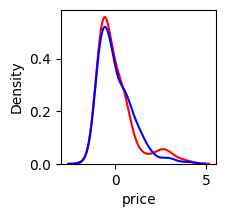

In [29]:
lm=LinearRegression()
lm.fit(X_train,y_train)
yhat_train=lm.predict(X_train)
MSE_train=mean_squared_error(y_train,yhat_train)
r2_train=r2_score(y_train,yhat_train)
print('For a train-size equal to',train_size*100,'%, the MSE and R-score on the training set are',MSE_train,'and',r2_train,',respectively.')

plt.figure(figsize=(2, 2))
ax1=sns.distplot(y_train,hist=False,color='r',label='Actual Values')
ax2=sns.distplot(yhat_train,hist=False,color='b',label='Predicted Values',ax=ax1)
plt.show()
plt.close()

So the fit is good. Since the fit is good, we can now see if the model is good also on the test set:

For a train-size equal to 90.0 %, the MSE and R-score on the test set are 0.13776916890439075 and 0.6070423045768709 ,respectively.
WE have MSE_test-MSE_train = -0.058394714339905035 and r2_test-r2_train = -0.2072047175594499


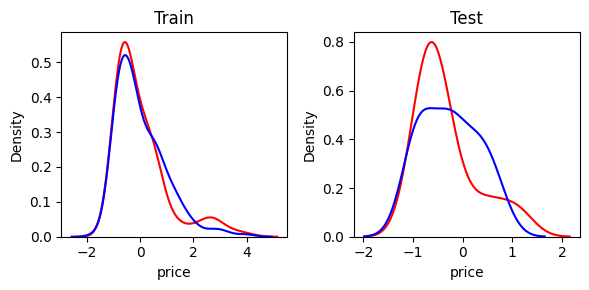

In [33]:
yhat_test=lm.predict(X_test)
MSE_test=mean_squared_error(y_test,yhat_test)
r2_test=r2_score(y_test,yhat_test)
print('For a train-size equal to',train_size*100,'%, the MSE and R-score on the test set are',MSE_test,'and',r2_test,',respectively.')

print ('WE have MSE_test-MSE_train =',MSE_test-MSE_train,'and r2_test-r2_train =',r2_test-r2_train)

def mykdeplot(y_train,y_test,yhat_train, yhat_test):
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 riga, 2 colonne

    # Primo plot: Train
    sns.kdeplot(y_train, color="r", label='y_train', ax=axes[0])
    sns.kdeplot(yhat_train, color="b", label='yhat_train', ax=axes[0])
    axes[0].set_title('Train')

    # Secondo plot: Test
    sns.kdeplot(y_test, color="r", label='y_test', ax=axes[1])
    sns.kdeplot(yhat_test, color="b", label='yhat_test', ax=axes[1])
    axes[1].set_title('Test')

    plt.tight_layout()
    plt.show()
    plt.close()

mykdeplot(y_train, y_test,yhat_train, yhat_test)

# K-fold validation

Here we do K-fold validation. Since before we have used a train_size of 0.9, we do 10-folds validation. The entire X is divided in 10 parts, and the train is done on $9/10$. Then we can take the mean and the std of the array of the scores: if the medium is near to the $R^2$ computed before and the std is low, the model is stable:

In [42]:
lm=LinearRegression()
scores=cross_val_score(lm,X,y,cv=10) #this is a numpy array containing the R^2-score computed on the test set (1/10) with model trained on the train set (9/10)
yhat=cross_val_predict(lm,X,y,cv=10)

#print(yhat)
print(scores,'\n')

print(scores.mean(),scores.std())

[ 0.66184045  0.14257918  0.7822969   0.7242706  -1.5499792   0.48974783
  0.60890719  0.53319587 -0.88559576  0.70833441] 

0.2215597466810424 0.7541486911047932


# Underfitting, Overfitting

We now study the underfitting and overfitting using the standard plot (x=complexity of the model, y= train and test error). In this case, the complexity can be represented by the order of the polynomial fit. We use a single variable x for semplicity.

[0.37453535445963615, 0.37194046720059537, 0.3593487951644633, 0.3503337788789574, 0.345473539367879, 0.330620946633325, 0.30656108076057537, 0.30198218617275335, 0.290074306254194, 0.23972108731384606, 0.22505061091930298, 0.2222491478443719, 0.21030563216176354] 

[0.30537805919205024, 0.30340979017802183, 0.31099494933307614, 0.3144044588840271, 0.30271216878183077, 0.3147931219539564, 0.2689931945431479, 0.2662254094540164, 0.32845538196483404, 0.3102005290882935, 0.2776395117524348, 0.27401153372946985, 0.5995702908848218]


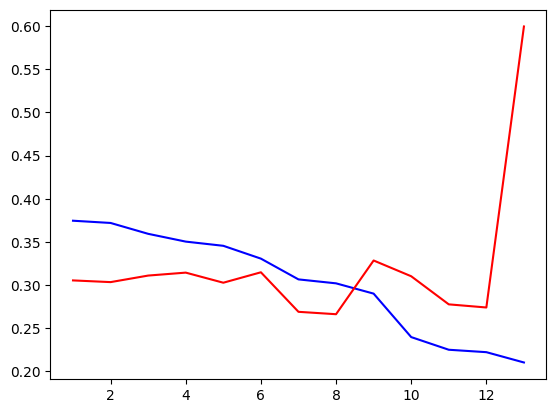

In [78]:
single=['horsepower']
target='price'
x = df[single] #fundamental to insert two [[]]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.45, random_state=1)

lm=LinearRegression()
MSE_train=list()
MSE_test=list()
for n in list(range(1,14)):
    pm=PolynomialFeatures(degree=n,include_bias=True)
    x_train_poly=pm.fit_transform(x_train)
    x_test_poly=pm.fit_transform(x_test)
    lm.fit(x_train_poly,y_train)
    yhat_train=lm.predict(x_train_poly)
    yhat_test=lm.predict(x_test_poly)
    MSE_train.append(mean_squared_error(y_train,yhat_train))
    MSE_test.append(mean_squared_error(y_test,yhat_test))

print(MSE_train,'\n')
print(MSE_test)
plt.plot(list(range(1,14)),MSE_train,color='blue')
plt.plot(list(range(1,14)),MSE_test,color='red')

# Ridge regression

Ridge regression is a regularizator of the cost function; in particular in comes from a gaussian prior. The hyperparameter is called $\alpha$ in scikit-learn:

In [84]:
pm=PolynomialFeatures(degree=3,include_bias=True)
x_train_poly=pm.fit_transform(x_train)
x_test_poly=pm.fit_transform(x_test)

for hyperpar in np.linspace(0,100,10): #the 0-th value should be the third entry in the ouput of the previous 'Underfitting, Overfitting'

    rm = Ridge(alpha=hyperpar) 
    rm.fit(x_train_poly, y_train)
    yhat_train=rm.predict(x_train_poly)
    yhat_test=rm.predict(x_test_poly)
    print(mean_squared_error(y_train,yhat_train),mean_squared_error(y_test,yhat_test))




0.3593487951644634 0.3109949493330761
0.3671706322366195 0.31822712289689803
0.38337107790732544 0.3321785004507499
0.4021586285253358 0.34814907287033775
0.4211224300630097 0.3641948354692757
0.4392599217391611 0.3795147843375369
0.45618952451915273 0.3938096952099122
0.47181138889868 0.4070067610444702
0.4861530611494738 0.4191347442205023
0.49929669813315586 0.4302653226630947


array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])